<a href="https://colab.research.google.com/github/sgcortes/25ForageYieldNWSpain/blob/main/V8_BoostrappingRFR_LGBM_XGB_OPTUNA_SHAP_PERMU_kgDM_RAD_Dia_Export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Regression Models Comparation (LightGBM, XGBoost. Adaboost, Random Forest Regressor. Hyperparameter Tuning with Optuna on best models)

Training and evaluation of 4 basic regression models and additional Hyperparameter optimization with Optuna for LightGBM,XGBoost and RFR.
The last one does not improve metrics with respect to the basic model.

 + LightGBM and XGBoost use categorical variables natively (no codification),
 + Random Forest Regressor and AdaBoost use onehot encoder.
 + No normalization on variable values (e.g. no standarization. This is not needed with ensemble models based on decision trees)
 + Radiation diary mean values (no acumulated radiation values during all the growing season).


In [2]:
!pip install lightgbm==4.6.0

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 7.6 MB/s eta 0:00:00


In [4]:
# 🔧 Instalación de librerías necesarias
try:
    import optuna
    import lightgbm
    import xgboost
    import shap
    import openpyxl
    import joblib
except ImportError:
    !pip install -q optuna lightgbm xgboost shap scikit-learn openpyxl


In [6]:
# 📦 Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [10]:
# 📂 Cargar datos
file_path = (r"C:\Users\hamza\Downloads\260324_ENG_MaizeForageSpainNWwtYearRadDay.xlsx")
df = pd.read_excel(file_path)

In [52]:
print("Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']")
objective_var = "kgDM/ha"

Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']


In [54]:
# Variables
categorical_features = ['Site', 'Cultivar']


y = df[objective_var]
X = df.drop(columns=['kgDM/ha', 'kgCP/ha', 'UFL/ha'])
# Convertir las columnas categóricas a 'category'
for col in categorical_features:
    X[col] = X[col].astype('category')

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##
print(X.columns,"\n")
#print(X.head)

Index(['Site', 'Cultivar', 'Elevation(m)', 'Radiation(Mj/m2day)',
       'Precipitation(mm)', 'Tmax(ºC)', 'Tmin(ºC)', 'WHC(mm)', 'C(%)', 'pH',
       'SowingDate(doy)', 'AnthesisDate(doy)', 'HarvestDate(doy)',
       'GrowingSeason(day)'],
      dtype='object') 



# 🔵 Basic Model  Training (no hyperparameter optimization). LightGBM, XGBoost, Adaboost and Random Forest Regressors.  

In [18]:
# LightGBM básico
lgb_basic = lgb.LGBMRegressor(categorical_feature=categorical_features)
lgb_basic.fit(X_train, y_train)
y_pred_lgb_basic = lgb_basic.predict(X_test)

# XGBoost básico
xgb_basic = xgb.XGBRegressor(enable_categorical=True, tree_method='hist')
xgb_basic.fit(X_train, y_train)
y_pred_xgb_basic = xgb_basic.predict(X_test)

# One-hot encoding para AdaBoost y Random Forest
X_encoded = pd.get_dummies(X, columns=categorical_features)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 🔸 AdaBoost Regressor (modelo base: DecisionTree)
adaboost_model = AdaBoostRegressor(random_state=42)
adaboost_model.fit(X_train_enc, y_train_enc)
y_pred_adaboost = adaboost_model.predict(X_test_enc)

# 🔸 Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_enc, y_train_enc)
y_pred_rf = rf_model.predict(X_test_enc)

C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 17457.263158


# 📈 Basic Models Evaluation

In [20]:
def evaluate(y_true, y_pred, name="Modelo"):
    print(f"\n{name}")
    print("R2:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

evaluate(y_test, y_pred_lgb_basic, name="LightGBM Basic")
evaluate(y_test, y_pred_xgb_basic, name="XGBoost Basic")
evaluate(y_test, y_pred_adaboost, name="AdaBoost Basic")
evaluate(y_test, y_pred_rf, name="Random Forest Basic")


LightGBM Basic
R2: 0.85913791768533
RMSE: 1232.4424416512527
MAE: 924.8192133075349
MAPE: 5.341202917102477

XGBoost Basic
R2: 0.8334429860115051
RMSE: 1340.142722787794
MAE: 1008.3441507273707
MAPE: 5.787737034581551

AdaBoost Basic
R2: 0.7615954764368469
RMSE: 1603.3444744795122
MAE: 1217.2303089471502
MAPE: 7.140365786825331

Random Forest Basic
R2: 0.8502983418663235
RMSE: 1270.524075457949
MAE: 968.5524482758622
MAPE: 5.542159958422331


### Variable importance for RMS global reduction

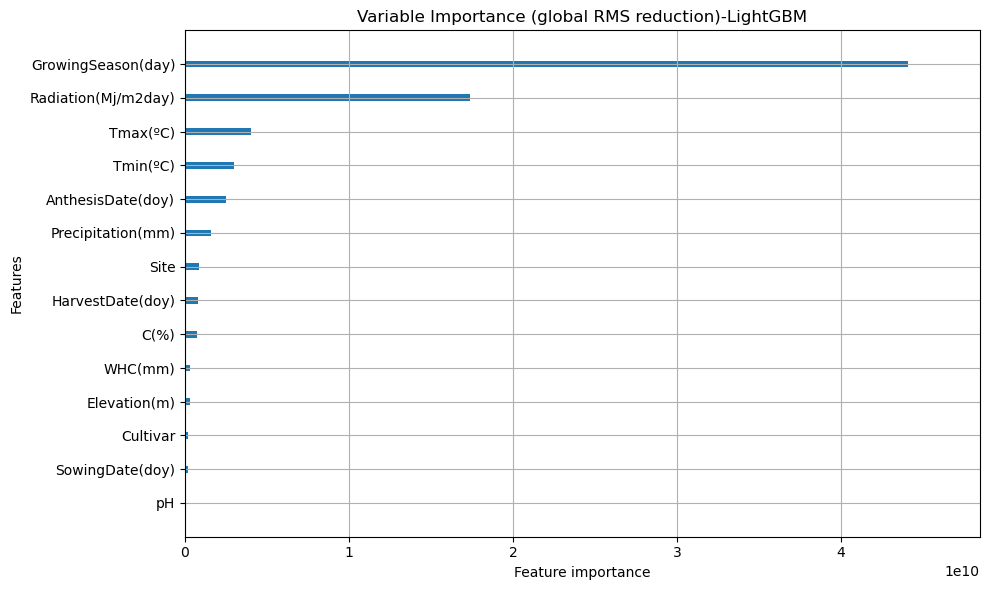

In [22]:
# Asumiendo que lgb_model ya está entrenado
booster = lgb_basic.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title("Variable Importance (global RMS reduction)-LightGBM")
plt.tight_layout()
plt.show()

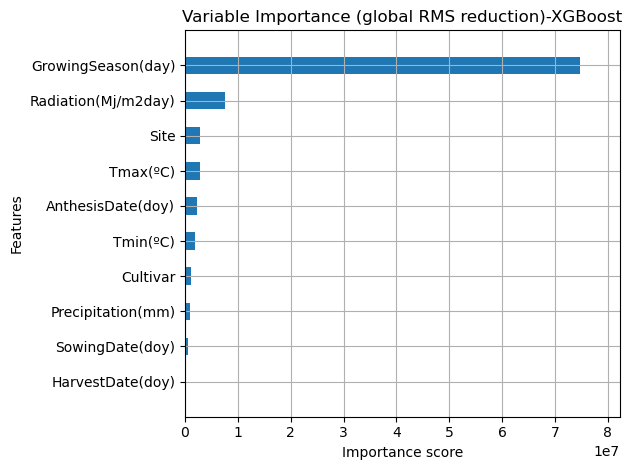

In [24]:
xgb.plot_importance(
    xgb_basic,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost')
plt.tight_layout()
plt.show()

### Variable importance for RMS reduction with Adaboost and Random Forest Regressor

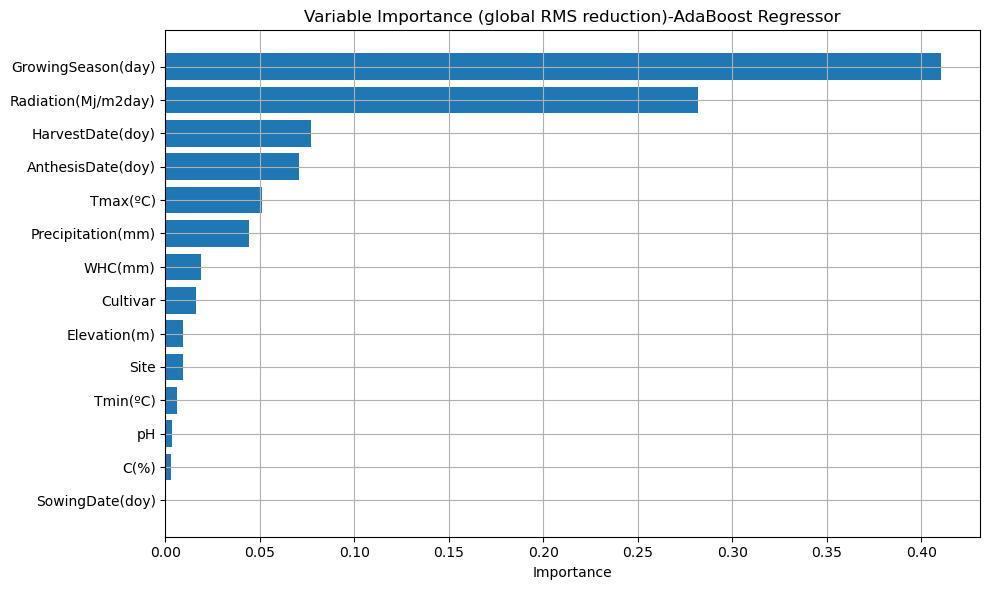

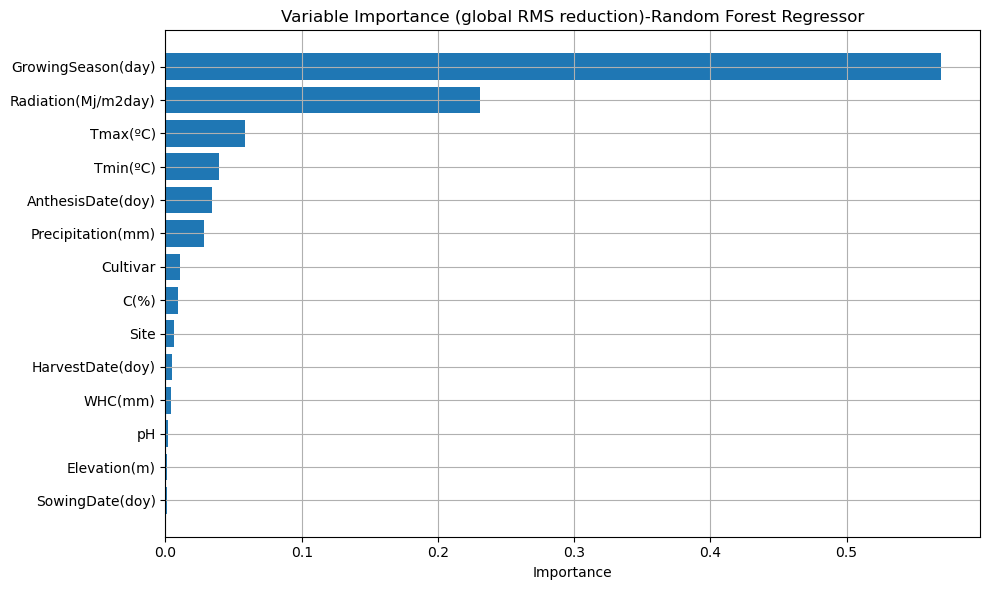

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Obtener nombres de las características
feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f'Feature_{i}' for i in range(X_train_enc.shape[1])]

def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Agrupar variables por prefijo (antes del "_") o quedarse con el nombre si no hay "_"
    def agrupar_nombre(col):
        if '_' in col:
            return col.split('_')[0]  # e.g., Cultivar_200 → Cultivar
        else:
            return col

    importance_df['grupo'] = importance_df['feature'].apply(agrupar_nombre)
    grouped = importance_df.groupby('grupo', as_index=False)['importance'].sum()

    # Orden descendente por importancia
    grouped_sorted = grouped.sort_values(by='importance', ascending=True)

    return grouped_sorted

def plot_feature_importances_grouped(importances, model_name):
    grouped_df = agrupar_importancias(importances, feature_names)

    plt.figure(figsize=(10, 6))
    plt.barh(grouped_df['grupo'], grouped_df['importance'])
    plt.xlabel('Importance')
    plt.title(f'Variable Importance (global RMS reduction)-{model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🔹 AdaBoost
plot_feature_importances_grouped(adaboost_model.feature_importances_, 'AdaBoost Regressor')

# 🔸 Random Forest
plot_feature_importances_grouped(rf_model.feature_importances_, 'Random Forest Regressor')


# 🧪 Hyperparameter Optimization with Optuna

In [28]:
def objective_lgb(trial):
    params = {
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = lgb.LGBMRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_xgb(trial):
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method': 'hist',
        'enable_categorical': True,
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    score = cross_val_score(model, X_train_enc, y_train_enc, cv=5, scoring='r2', n_jobs=-1).mean()
    return score


study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=30)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)


[I 2025-08-15 22:50:03,078] A new study created in memory with name: no-name-f01757a0-3d5a-4ae5-b655-b4573f08d7a4
[I 2025-08-15 22:50:03,272] Trial 0 finished with value: 1338.0190014248078 and parameters: {'learning_rate': 0.24608248446074424, 'num_leaves': 84, 'max_depth': 8, 'min_child_samples': 81, 'subsample': 0.7870552956449952, 'colsample_bytree': 0.6569547320074951}. Best is trial 0 with value: 1338.0190014248078.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 22:50:03,386] Trial 1 finished with value: 1283.0429839230699 and parameters: {'learning_rate': 0.15910895217109974, 'num_leaves': 163, 'max_depth': 4, 'min_child_samples': 37, 'subsample': 0.8751058197364854, 'colsample_bytree': 0.8417077180673146}. Best is trial 1 with value: 1283.0429839230699.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 22:50:03,538] Trial 2 finished with value: 1281.7309589159838 and parameters: {'learning_rate': 0.1156936695886155, 'num_leaves': 119, 'max_depth': 13, 'min_child_samples': 46, 'subsample': 0.745362745106184, 'colsample_bytree': 0.5744047257914118}. Best is trial 2 with value: 1281.7309589159838.
[I 2025-08-15 22:50:03,674] Trial 3 finished with value: 1324.5411179079333 and parameters: {'learning_rate': 0.23007835348021272, 'num_leaves': 134, 'max_depth': 9, 'min_child_samples': 64, 'subsample': 0.745517427943358, 'colsample_bytree': 0.9874219208032347}. Best is trial 2 with value: 1281.7309589159838.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 17439.394397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 22:50:03,845] Trial 4 finished with value: 1278.286324677308 and parameters: {'learning_rate': 0.2553100209646898, 'num_leaves': 27, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.937135998214979, 'colsample_bytree': 0.5820567523932946}. Best is trial 4 with value: 1278.286324677308.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:04,014] Trial 5 finished with value: 1275.0421737291833 and parameters: {'learning_rate': 0.14120365632191223, 'num_leaves': 181, 'max_depth': 14, 'min_child_samples': 41, 'subsample': 0.7205471385341529, 'colsample_bytree': 0.6005236765732781}. Best is trial 5 with value: 1275.0421737291833.
[I 2025-08-15 22:50:04,118] Trial 6 finished with value: 1339.0691209806116 and parameters: {'learning_rate': 0.2857729044937548, 'num_leaves': 189, 'max_depth': 4, 'min_child_samples': 69, 'subsample': 0.8163340158528336, 'colsample_bytree': 0.9879091205046343}. Best is trial 5 with value: 1275.0421737291833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:04,246] Trial 7 finished with value: 1319.974000738302 and parameters: {'learning_rate': 0.19999757861414205, 'num_leaves': 95, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5094111693929559, 'colsample_bytree': 0.6813437557697009}. Best is trial 5 with value: 1275.0421737291833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 22:50:04,409] Trial 8 finished with value: 1262.3708353669986 and parameters: {'learning_rate': 0.21999550418640604, 'num_leaves': 124, 'max_depth': 12, 'min_child_samples': 34, 'subsample': 0.9736593131744962, 'colsample_bytree': 0.6215243328027935}. Best is trial 8 with value: 1262.3708353669986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17421.316073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 22:50:04,531] Trial 9 finished with value: 1578.9637869510825 and parameters: {'learning_rate': 0.028269044749147612, 'num_leaves': 191, 'max_depth': 10, 'min_child_samples': 84, 'subsample': 0.668072161038443, 'colsample_bytree': 0.8705392371747196}. Best is trial 8 with value: 1262.3708353669986.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:04,806] Trial 10 finished with value: 1244.9443822071055 and parameters: {'learning_rate': 0.06526482009407242, 'num_leaves': 56, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.9917592017652949, 'colsample_bytree': 0.7840534517482662}. Best is trial 10 with value: 1244.9443822071055.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:05,078] Trial 11 finished with value: 1246.783795756717 and parameters: {'learning_rate': 0.04851451301397665, 'num_leaves': 53, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.9852652800060663, 'colsample_bytree': 0.7690171279073627}. Best is trial 10 with value: 1244.9443822071055.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:05,380] Trial 12 finished with value: 1261.4693026913114 and parameters: {'learning_rate': 0.04146215592204936, 'num_leaves': 45, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.999858159169326, 'colsample_bytree': 0.7621720473777095}. Best is trial 10 with value: 1244.9443822071055.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 22:50:05,607] Trial 13 finished with value: 1228.1195444593545 and parameters: {'learning_rate': 0.07782754286375332, 'num_leaves': 63, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.9101709476647426, 'colsample_bytree': 0.7585296301452631}. Best is trial 13 with value: 1228.1195444593545.
[I 2025-08-15 22:50:05,831] Trial 14 finished with value: 1244.3640831259245 and parameters: {'learning_rate': 0.08993794310666182, 'num_leaves': 74, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.8937345953790551, 'colsample_bytree': 0.8461760362736634}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 22:50:06,000] Trial 15 finished with value: 1236.2951980075363 and parameters: {'learning_rate': 0.09359903297842566, 'num_leaves': 81, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.8845070021512996, 'colsample_bytree': 0.5002333104774381}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 22:50:06,126] Trial 16 finished with value: 1406.9157380354372 and parameters: {'learning_rate': 0.09084296797437034, 'num_leaves': 21, 'max_depth': 6, 'min_child_samples': 97, 'subsample': 0.857793466501274, 'colsample_bytree': 0.5006385986473851}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:06,290] Trial 17 finished with value: 1957.7595385481575 and parameters: {'learning_rate': 0.011007968994610207, 'num_leaves': 101, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.6331912405966412, 'colsample_bytree': 0.5000298289646067}. Best is trial 13 with value: 1228.1195444593545.
[I 2025-08-15 22:50:06,412] Trial 18 finished with value: 1286.5966945225348 and parameters: {'learning_rate': 0.1717060720715855, 'num_leaves': 76, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.9255945771391267, 'colsample_bytree': 0.6889483026405345}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:06,588] Trial 19 finished with value: 1321.8424826365501 and parameters: {'learning_rate': 0.11711531976263967, 'num_leaves': 68, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.8366060114308925, 'colsample_bytree': 0.9228277441388542}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:06,771] Trial 20 finished with value: 1320.87757621841 and parameters: {'learning_rate': 0.07354717775551267, 'num_leaves': 152, 'max_depth': 10, 'min_child_samples': 58, 'subsample': 0.9163975723715725, 'colsample_bytree': 0.7235749573115813}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17421.316073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 22:50:06,984] Trial 21 finished with value: 1246.7078568472734 and parameters: {'learning_rate': 0.10450493256678406, 'num_leaves': 85, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.8853839637057629, 'colsample_bytree': 0.8257217653737602}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:07,219] Trial 22 finished with value: 1260.8311948718997 and parameters: {'learning_rate': 0.07980972368486344, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.798179708636591, 'colsample_bytree': 0.9061557198035368}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:07,406] Trial 23 finished with value: 1240.5758016083958 and parameters: {'learning_rate': 0.14092755833259424, 'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 32, 'subsample': 0.9146017104925641, 'colsample_bytree': 0.8151303355117098}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17421.316073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 22:50:07,569] Trial 24 finished with value: 1243.429976598992 and parameters: {'learning_rate': 0.18517623048966816, 'num_leaves': 59, 'max_depth': 7, 'min_child_samples': 33, 'subsample': 0.9426956848158312, 'colsample_bytree': 0.7966697462846666}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:07,743] Trial 25 finished with value: 1278.7904915790016 and parameters: {'learning_rate': 0.14029196088859486, 'num_leaves': 103, 'max_depth': 8, 'min_child_samples': 46, 'subsample': 0.8627668524952239, 'colsample_bytree': 0.7491942486350631}. Best is trial 13 with value: 1228.1195444593545.
[I 2025-08-15 22:50:07,901] Trial 26 finished with value: 1242.587349103512 and parameters: {'learning_rate': 0.13447938364930412, 'num_leaves': 36, 'max_depth': 6, 'min_child_samples': 32, 'subsample': 0.952386232898736, 'colsample_bytree': 0.7186864240885924}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:08,071] Trial 27 finished with value: 1317.5502466343867 and parameters: {'learning_rate': 0.0609225478574307, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 46, 'subsample': 0.8326432132943286, 'colsample_bytree': 0.90485614779543}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 22:50:08,253] Trial 28 finished with value: 1246.8410659531826 and parameters: {'learning_rate': 0.11002491483470901, 'num_leaves': 67, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.7756971449436995, 'colsample_bytree': 0.8116878755170844}. Best is trial 13 with value: 1228.1195444593545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 22:50:08,549] Trial 29 finished with value: 1286.666716123911 and parameters: {'learning_rate': 0.16203547150817693, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.9068430855022716, 'colsample_bytree': 0.6525375562544491}. Best is trial 13 with value: 1228.1195444593545.
[I 2025-08-15 22:50:08,550] A new study created in memory with name: no-name-0eb993cb-73b3-4696-8a8f-71b9e26de0bb
[I 2025-08-15 22:50:08,892] Trial 0 finished with value: 1248.0515168715824 and parameters: {'learning_rate': 0.2062067406056016, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.8586292526852406, 'colsample_bytree': 0.7786939727593396}. Best is trial 0 with value: 1248.0515168715824.
[I 2025-08-15 22:50:09,275] Trial 1 finished with value: 1287.0447673243218 and parameters: {'learning_rate': 0.1960945477181477, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.5128381075136225, 'colsample_bytree': 0.8583068326221726}. Best is trial 0 with value: 1248.051516

# 🚀 Regressors Training on Optimized Models

In [29]:
lgb_best = lgb.LGBMRegressor(**study_lgb.best_params, categorical_feature=categorical_features)
lgb_best.fit(X_train, y_train)
y_pred_lgb_best = lgb_best.predict(X_test)

xgb_best = xgb.XGBRegressor(**study_xgb.best_params, enable_categorical=True, tree_method='hist')
xgb_best.fit(X_train, y_train)
y_pred_xgb_best = xgb_best.predict(X_test)

# Entrenar modelo con mejores hiperparámetros
rf_best = RandomForestRegressor(**study_rf.best_params)
rf_best.fit(X_train_enc, y_train_enc)
y_pred_rf_best = rf_best.predict(X_test_enc)

evaluate(y_test, y_pred_lgb_best, name="LightGBM Optuna")
evaluate(y_test, y_pred_xgb_best, name="XGBoost Optuna")
evaluate(y_test, y_pred_rf_best, name="RFR Optuna")

C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 17457.263158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

### Global Variable importance for Optimized Regressors (XGBoost and LightGBM)

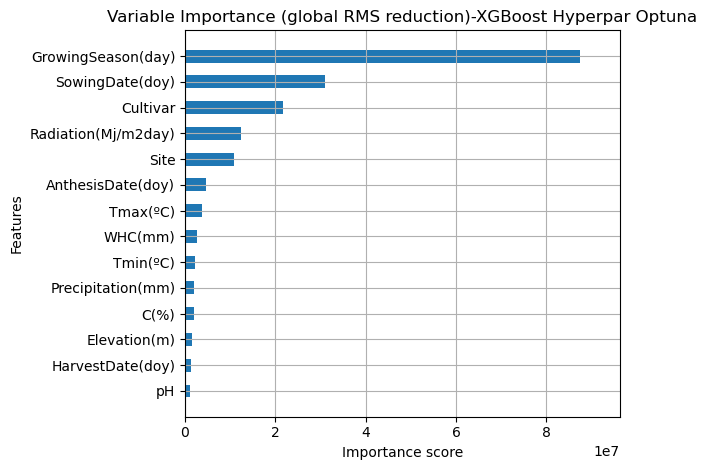

In [32]:
xgb.plot_importance(
    xgb_best,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost Hyperpar Optuna')
plt.tight_layout()
plt.show()

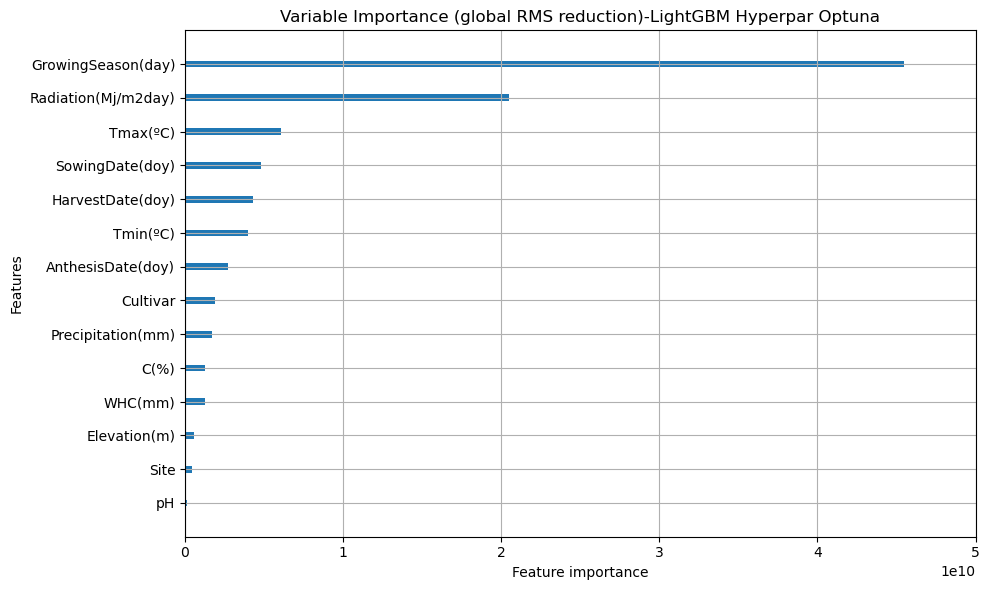

In [34]:
booster = lgb_best.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title('Variable Importance (global RMS reduction)-LightGBM Hyperpar Optuna')
plt.tight_layout()
plt.show()

### Variable permutation  Tests

📊 Test de Permutación - LightGBM Optuna


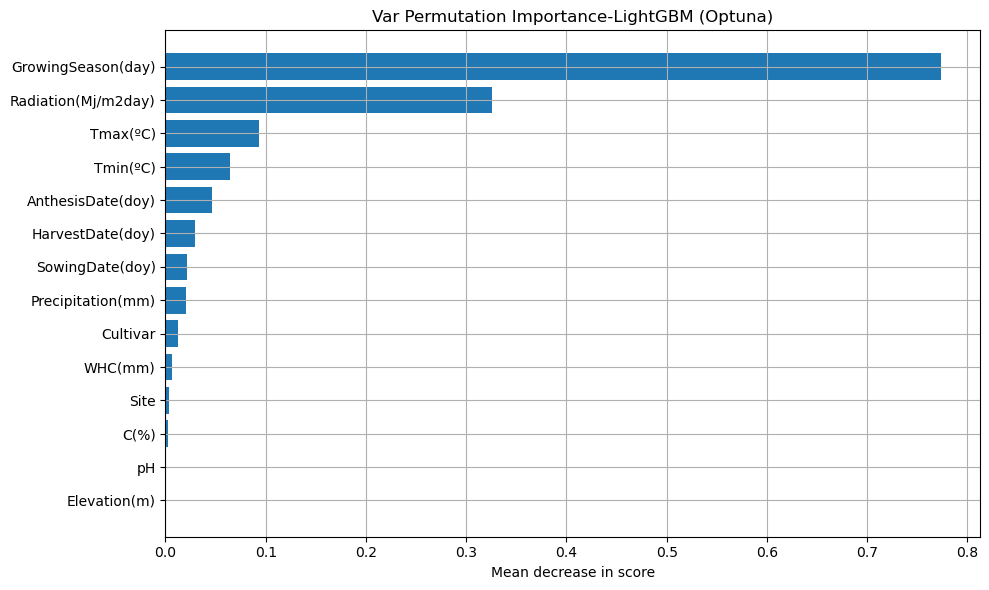

Var Permutation Importance-XGBoost (Optuna)


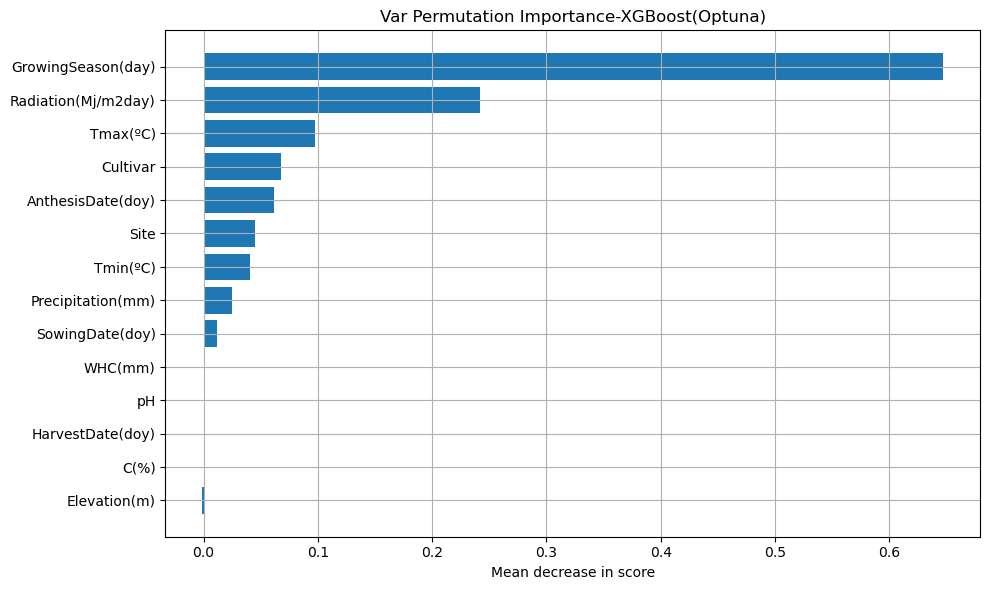

In [36]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Test de permutación para LightGBM optimizado
print("📊 Test de Permutación - LightGBM Optuna")
perm_lgb = permutation_importance(
    lgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_lgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_lgb.importances_mean[sorted_idx])
plt.title("Var Permutation Importance-LightGBM (Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Test de permutación para XGBoost optimizado
print("Var Permutation Importance-XGBoost (Optuna)")
perm_xgb = permutation_importance(
    xgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_xgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_xgb.importances_mean[sorted_idx])
plt.title("Var Permutation Importance-XGBoost(Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()


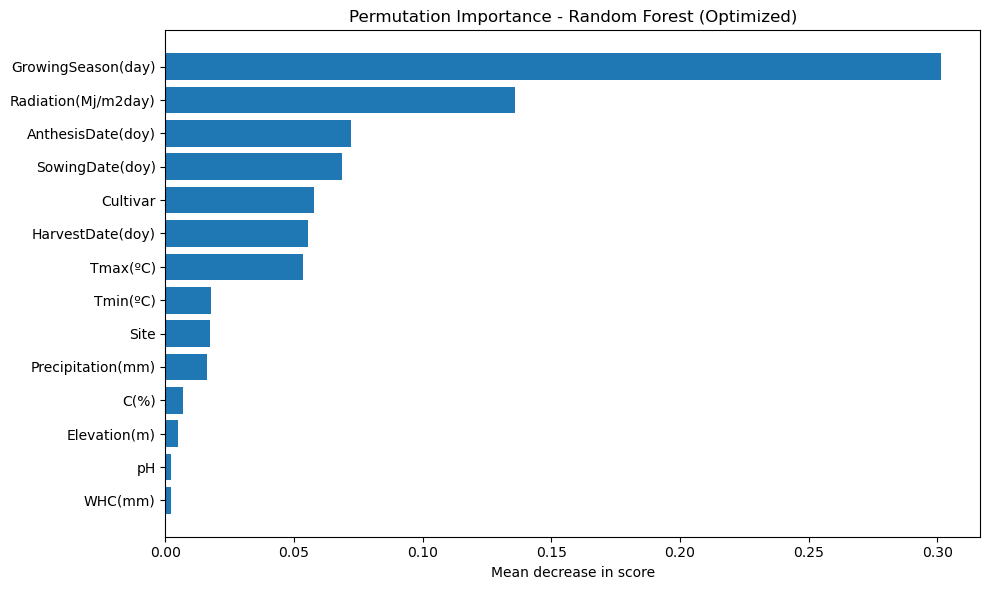

In [38]:

# 📊 Permutation importance - Random Forest (optimized)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

perm_rf = permutation_importance(rf_best, X_test_enc, y_test_enc, n_repeats=10, random_state=42, n_jobs=-1)
importances_rf = perm_rf.importances_mean

# Agrupar por variable base (si es one-hot)
def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df['grupo'] = importance_df['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)
    return importance_df.groupby('grupo', as_index=False)['importance'].sum().sort_values(by='importance', ascending=True)

feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f"Feature_{i}" for i in range(X_train_enc.shape[1])]
df_rf_perm = agrupar_importancias(importances_rf, feature_names)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(df_rf_perm['grupo'], df_rf_perm['importance'])
plt.title("Permutation Importance - Random Forest (Optimized)")
plt.xlabel("Mean decrease in score")
plt.tight_layout()
plt.show()


### SHAP Values

📌 SHAP Values for Optimized LightGBM



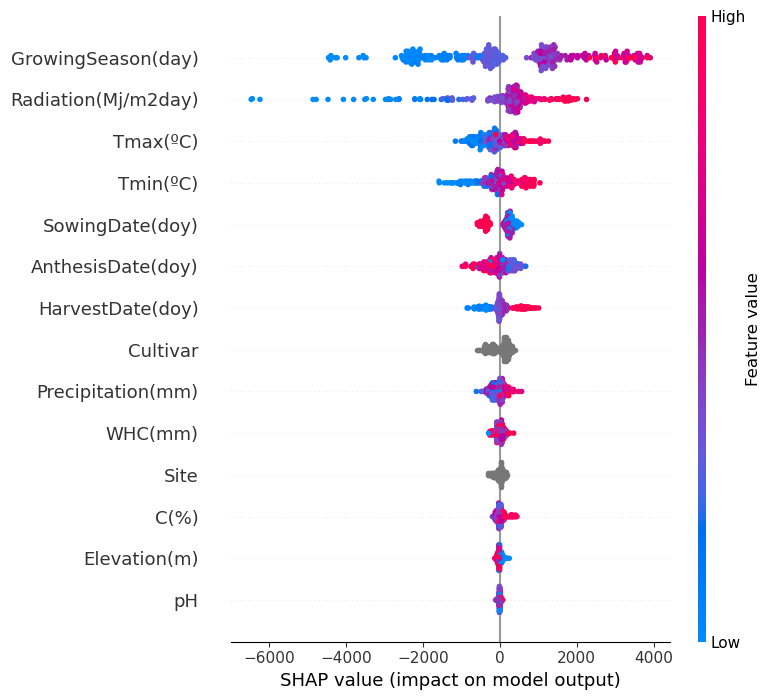

In [40]:
# 🔍 Calcular y visualizar SHAP values para LightGBM
import shap
shap.initjs()

# TreeExplainer para modelos basados en árboles como LightGBM
explainer_lgb = shap.TreeExplainer(lgb_best)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Gráfico resumen
shap.summary_plot(shap_values_lgb, X_test)

📌 SHAP for Optmized XGBoost

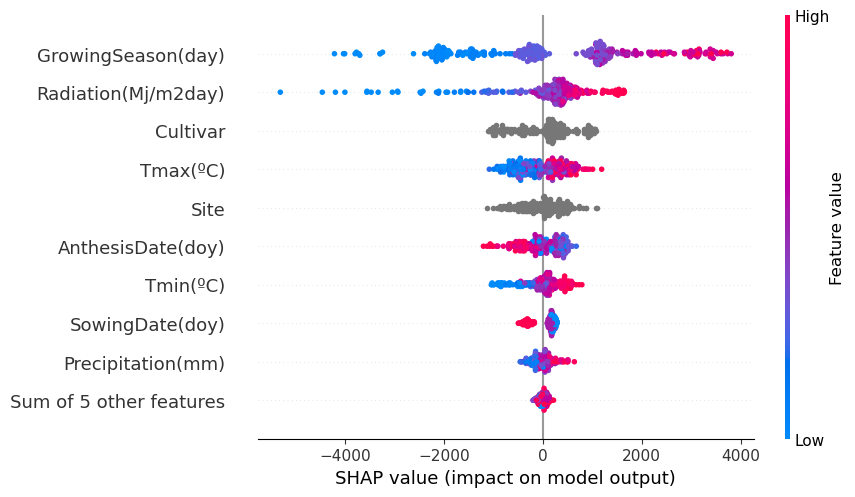

In [42]:
# 🔍 Calcular y visualizar SHAP values para XGBoost
explainer_xgb = shap.TreeExplainer(xgb_best)
shap_values_xgb = explainer_xgb(X_test)

# Gráfico resumen SHAP
shap.plots.beeswarm(shap_values_xgb)

###  💾 SAVING OPTIMIZED MODELS

In [44]:
import joblib

joblib.dump(lgb_best, "lgb_best_model.pkl")
joblib.dump(xgb_best, "xgb_best_model.pkl")
joblib.dump(rf_best, "rfr_best_model.pkl")

print("Succesfully exported models.")


Succesfully exported models.


## PREDICTION

In [46]:
# 📦 Cargar modelos y realizar predicciones con nuevos datos
lgbm_loaded = joblib.load("lgb_best_model.pkl")
xgb_loaded = joblib.load("xgb_best_model.pkl")
rfr_loaded = joblib.load("rfr_best_model.pkl")

# Reemplazar X_nuevos_datos por datos reales
# y_pred_lgb = lgb_loaded.predict(X_nuevos_datos)
# y_pred_xgb = xgb_loaded.predict(X_nuevos_datos)
# y_pred_rfr = rfr_loaded.predict(X_nuevos_datos) # onehto codification needed

## Booststrappint for confidence intervals on LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 17526.136324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

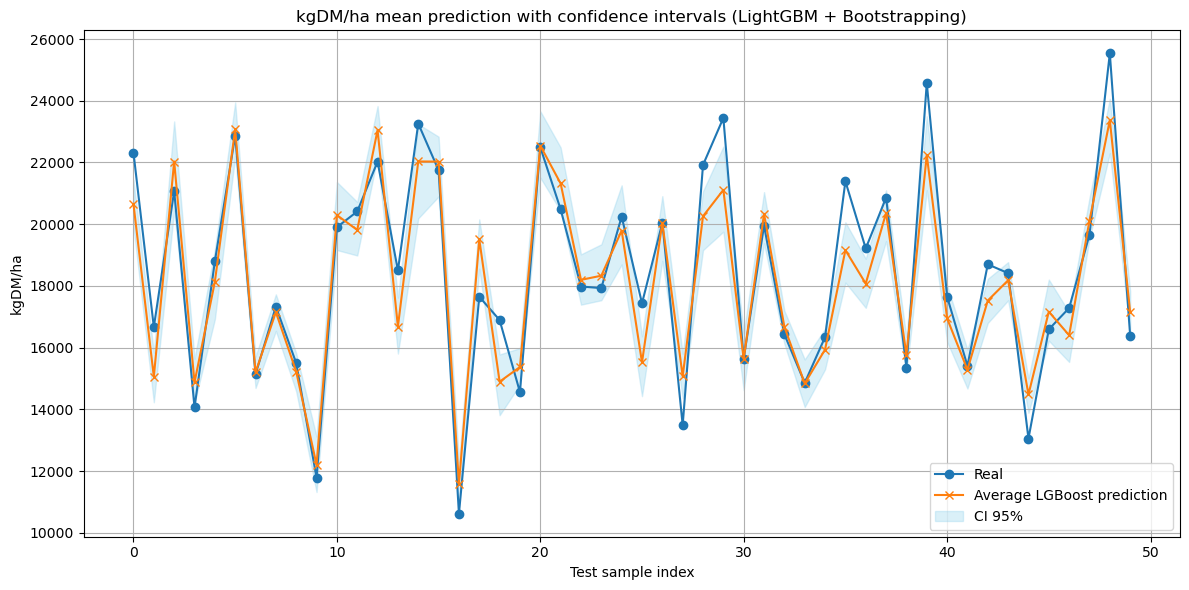

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb

# -------------------------
# Bootstrapping parameters
# -------------------------
n_bootstraps = 100
bootstrap_preds_lgb = []

# -------------------------
# Bootstrapped model training
# -------------------------
for i in range(n_bootstraps):
    # Re-muestreo con reemplazo
    X_resampled, y_resampled = resample(X_train, y_train, random_state=42+i)

    # Entrenamiento con hiperparámetros óptimos
    model_lgb = lgb.LGBMRegressor(**study_lgb.best_params, random_state=42+i)
    model_lgb.fit(X_resampled, y_resampled, categorical_feature=categorical_features)

    # Predicción sobre test
    y_pred = model_lgb.predict(X_test)
    bootstrap_preds_lgb.append(y_pred)

# -------------------------
# Aggregated predictions and confidence intervals
# -------------------------
bootstrap_preds_lgb = np.array(bootstrap_preds_lgb)
y_pred_mean_lgb = bootstrap_preds_lgb.mean(axis=0)
y_pred_lower_lgb = np.percentile(bootstrap_preds_lgb, 2.5, axis=0)
y_pred_upper_lgb = np.percentile(bootstrap_preds_lgb, 97.5, axis=0)

# -------------------------
# Evaluation metrics
# -------------------------
print("📊 R2 LGBoost:", r2_score(y_test, y_pred_mean_lgb))
print("📉 RMSE LGBoost:", np.sqrt(mean_squared_error(y_test, y_pred_mean_lgb)))

# -------------------------
# Visualization
# -------------------------
plt.figure(figsize=(12, 6))
x_range = np.arange(len(y_test[:50]))  # mostrar primeras 50 muestras
plt.plot(x_range, y_test[:50], label='Real', marker='o')
plt.plot(x_range, y_pred_mean_lgb[:50], label='Average LGBoost prediction', marker='x')
plt.fill_between(x_range, y_pred_lower_lgb[:50], y_pred_upper_lgb[:50], color='skyblue', alpha=0.3, label='CI 95%')
plt.title("kgDM/ha mean prediction with confidence intervals (LightGBM + Bootstrapping)")
plt.xlabel("Test sample index")
plt.ylabel("kgDM/ha")
plt.legend()
plt.tight_layout()
plt.grid('on')
plt.show()


### Percentage of test samples in the 95% CI

In [50]:
# Asegurémonos de que y_test esté en formato array (o Series de pandas)
import numpy as np

# Convertir a array en caso de ser una Series
y_test_array = np.array(y_test)

# Calcular un booleano para cada muestra: True si el valor real está dentro del intervalo, False de lo contrario.
in_interval = (y_test_array >= y_pred_lower_lgb) & (y_test_array <= y_pred_upper_lgb)

# Calcular el porcentaje de muestras que cumplen con la condición
percentage_in_interval = in_interval.mean() * 100

print("Percetange of samples inside the 95% confidence interval: {:.2f}%".format(percentage_in_interval))


Percetange of samples inside the 95% confidence interval: 55.17%


In [ ]:
### Hamza / Anas Code

[I 2025-08-15 23:23:24,542] A new study created in memory with name: MLP_kgCP/ha
[I 2025-08-15 23:23:50,309] Trial 0 finished with value: 1059.2556409171734 and parameters: {'h1': 39, 'use_h2': 0, 'alpha': 1.8800458355447984e-06, 'lr': 0.00010530242309885688, 'activation': 'tanh', 'batch_size': 64}. Best is trial 0 with value: 1059.2556409171734.
[I 2025-08-15 23:24:11,457] Trial 1 finished with value: 58.73633092313365 and parameters: {'h1': 77, 'use_h2': 0, 'alpha': 0.01891562115623018, 'lr': 0.0022499058435792164, 'activation': 'relu', 'batch_size': 128}. Best is trial 1 with value: 58.73633092313365.
[I 2025-08-15 23:24:29,774] Trial 2 finished with value: 78.93787315495281 and parameters: {'h1': 124, 'use_h2': 1, 'h2': 78, 'alpha': 0.007953994330053497, 'lr': 0.004128999472235978, 'activation': 'relu', 'batch_size': 128}. Best is trial 1 with value: 58.73633092313365.
[I 2025-08-15 23:24:59,790] Trial 3 finished with value: 48.47714827866414 and parameters: {'h1': 156, 'use_h2': 1


MLP (kgCP/ha)
R2:   0.9636
RMSE: 45.3494
MAE:  32.4232
MAPE: 3.40%


,feature,importance
25,num__kgDM/ha,462.134879
26,num__UFL/ha,211.654038
11,cat__Cultivar_G300,107.177873
21,num__SowingDate(doy),106.366425
12,cat__Cultivar_G400,101.200838
0,cat__Site_Barcia,98.293959
4,cat__Site_Ribadeo,93.149988
8,cat__Cultivar_A300,87.754705
5,cat__Site_Sarria,85.953196
6,cat__Site_Villaviciosa,85.723093


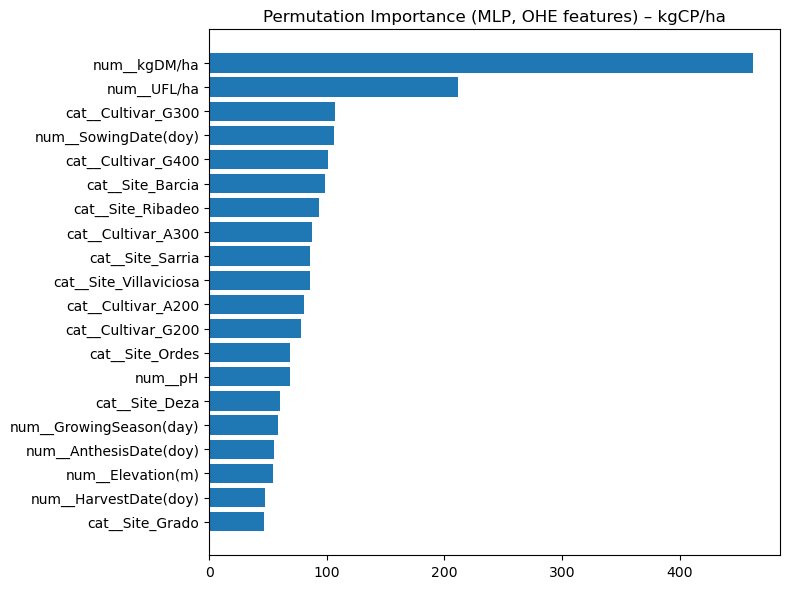

Saved: models/mlp_cp.pkl


In [56]:
import os, joblib, numpy as np, pandas as pd, optuna
from IPython.display import display
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

DATA_PATH = "260324_ENG_MaizeForageSpainNWwtYearRadDay.xlsx"
if 'df' not in globals():
    df = pd.read_excel(DATA_PATH)

objective_var = 'kgCP/ha'

cat_cols = [c for c in df.columns if c.lower() in ('site','cultivar')]
num_cols = [c for c in df.columns if c not in cat_cols + [objective_var]]

X = df[cat_cols + num_cols].copy()
y = df[objective_var].astype(float).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def preprocessor():
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    return ColumnTransformer([('cat', ohe, cat_cols), ('num', StandardScaler(), num_cols)], remainder='drop')

def make_pipe(hidden=(128,64), alpha=1e-3, lr=1e-3, act='relu', batch=128):
    return Pipeline([('prep', preprocessor()),
                     ('model', MLPRegressor(hidden_layer_sizes=hidden, alpha=alpha,
                                            learning_rate_init=lr, activation=act,
                                            batch_size=batch, max_iter=1000, random_state=42))])

def objective(trial):
    h1 = trial.suggest_int('h1', 32, 256, log=True)
    use_h2 = trial.suggest_categorical('use_h2', [0,1])
    hidden = (h1,) if use_h2==0 else (h1, trial.suggest_int('h2', 16, 256, log=True))
    alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
    lr    = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    act   = trial.suggest_categorical('activation', ['relu','tanh'])
    batch = trial.suggest_categorical('batch_size', [32,64,128,256])
    pipe  = make_pipe(hidden, alpha, lr, act, batch)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    s = cross_val_score(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1).mean()
    return -s

study = optuna.create_study(direction='minimize', study_name=f"MLP_{objective_var}")
study.optimize(objective, n_trials=40, show_progress_bar=False)
p = study.best_params
hidden = (p['h1'],) if p['use_h2']==0 else (p['h1'], p['h2'])

pipe = make_pipe(hidden, p['alpha'], p['lr'], p['activation'], p['batch_size'])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae = float(mean_absolute_error(y_test, y_pred))
mape = float(np.mean(np.abs((y_test - y_pred) / np.clip(y_test, 1e-9, None))) * 100)

print(f"\nMLP ({objective_var})")
print(f"R2:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

Xt_test = pipe.named_steps['prep'].transform(X_test)
est = pipe.named_steps['model']
pi = permutation_importance(est, Xt_test, y_test, n_repeats=10, random_state=42, scoring='neg_root_mean_squared_error')
feat_names = pipe.named_steps['prep'].get_feature_names_out()
imp_df = pd.DataFrame({'feature': feat_names, 'importance': pi.importances_mean}).sort_values('importance', ascending=False).head(20)
display(imp_df)

plt.figure(figsize=(8, 6))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.title(f'Permutation Importance (MLP, OHE features) – {objective_var}')
plt.tight_layout()
plt.show()

os.makedirs('models', exist_ok=True)
short = {'kgDM/ha':'dm','UFL/ha':'ufl','kgCP/ha':'cp'}[objective_var]
out_path = f"models/mlp_{short}.pkl"
joblib.dump(pipe, out_path)
print(f"Saved: {out_path}")
